# Clustering the Beaded Helix With Non-Uniform Frame Weights

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from shapeGMMTorch.utils import cross_validate_component_scan, sgmm_fit_with_attempts
import torch

## Read trajectory

In [2]:
prmtopFileName = "helix_template.pdb"
trajFileName = "helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 10001
Number of atoms in selection: 12


## Perform Cross Validation with Uniform Weights

Here we will perform a cluster scan assuming each frame has the same weight.  This is exactly what we did in the other notebook.

In [3]:
# define cluster array
component_array = np.arange(1,6,1).astype(int)
print(component_array)

[1 2 3 4 5]


In [4]:
covar_type = "kronecker"
device = torch.device("cpu")
dtype  = torch.float64

In [5]:
# run component CV scan
n_training_sets = 3
n_attempts = 10
train, cv = cross_validate_component_scan(traj_data,component_array, 
                                            covar_type = "kronecker", 
                                            n_training_sets=n_training_sets,
                                            n_attempts=n_attempts,
                                            device = device,
                                            dtype=dtype
                                        )

Number of atoms: 12
Covariance type: kronecker
Number of frames to train each model: 9000
Number of frames to predict each model: 1001
Number of training sets: 3
Number of attempts per set/component: 10
Component array: [1 2 3 4 5]
Init Component Method   : kmeans++
Random seed             : 1234
   Training Set    N Components         Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------------------------------------
              1               1               1             35.8623           8.635
              1               2               1             40.2175           2.975
              1               2               2             40.2173           2.027
              1               2               3             40.2114           1.982
              1               2               4             40.2171           1.851
              1               2               5             39.4178          13.041
              1     

## Perform Cross Validation with ENM Weights for each Frame

I have calculated the weight of each frame of this trajectory assuming it came from an ENM model.  This should bias towards only finding the right- and left-handed helices and ignoring anything else.  

In [6]:
# load the weights
frame_weights = np.loadtxt("enm_weights.dat")
print(np.sum(frame_weights))

1.0


In [7]:
# CV scan with non-uniform weights
# run component CV scan
n_training_sets = 3
n_attempts = 10
enm_train, enm_cv = cross_validate_component_scan(traj_data,component_array, 
                                                  frame_weights = frame_weights,
                                                  covar_type = "kronecker", 
                                                  n_training_sets=n_training_sets,
                                                  n_attempts=n_attempts,
                                                  device = device,
                                                  dtype=dtype
                                                 )

Number of atoms: 12
Covariance type: kronecker
Number of frames to train each model: 9000
Number of frames to predict each model: 1001
Number of training sets: 3
Number of attempts per set/component: 10
Component array: [1 2 3 4 5]
Init Component Method   : kmeans++
Random seed             : 1234
   Training Set    N Components         Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------------------------------------
              1               1               1             42.9385           6.025
              1               2               1             47.9898           0.531
              1               2               2             47.9891           0.532
              1               2               3             47.9888           0.533
              1               2               4             47.9890           0.532
              1               2               5             43.9754           5.619
              1     

## Perform Cross-Validation with Uniformly Random Weights for each Frame

In [8]:
# load the weights
random_frame_weights = np.random.rand(frame_weights.shape[0])
random_frame_weights /= np.sum(random_frame_weights)

In [9]:
# CV scan with non-uniform weights
random_train, random_cv = cross_validate_component_scan(traj_data,component_array, 
                                                  frame_weights = random_frame_weights,
                                                  covar_type = "kronecker", 
                                                  n_training_sets=n_training_sets,
                                                  n_attempts=n_attempts,
                                                  device = device,
                                                  dtype=dtype
                                                 )

Number of atoms: 12
Covariance type: kronecker
Number of frames to train each model: 9000
Number of frames to predict each model: 1001
Number of training sets: 3
Number of attempts per set/component: 10
Component array: [1 2 3 4 5]
Init Component Method   : kmeans++
Random seed             : 1234
   Training Set    N Components         Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------------------------------------
              1               1               1             35.7799           0.467
              1               2               1             40.2305           2.211
              1               2               2             39.2751          15.253
              1               2               3             40.4198           2.125
              1               2               4             40.1643           2.477
              1               2               5             39.3238          13.648
              1     

### Save and load log likelihood data for quick use

In [13]:
# save data (optional - don't have to do this)
np.savetxt("uniform_frame_weights_ll_train.dat", train)
np.savetxt("uniform_frame_weights_ll_cv.dat", cv)
np.savetxt("enm_frame_weights_ll_train.dat", enm_train)
np.savetxt("enm_frame_weights_ll_cv.dat", enm_cv)
np.savetxt("random_frame_weights_ll_train.dat", random_train)
np.savetxt("random_frame_weights_ll_cv.dat", random_cv)

In [6]:
# load data
# NOTE - only do this if you want to overwrite active arrays
train = np.loadtxt("uniform_frame_weights_ll_train.dat")
cv = np.loadtxt("uniform_frame_weights_ll_cv.dat")
enm_train = np.loadtxt("enm_frame_weights_ll_train.dat")
enm_cv = np.loadtxt("enm_frame_weights_ll_cv.dat")
random_train = np.loadtxt("random_frame_weights_ll_train.dat")
random_cv = np.loadtxt("random_frame_weights_ll_cv.dat")

## Make Log Likelihood vs number of Cluster Plots

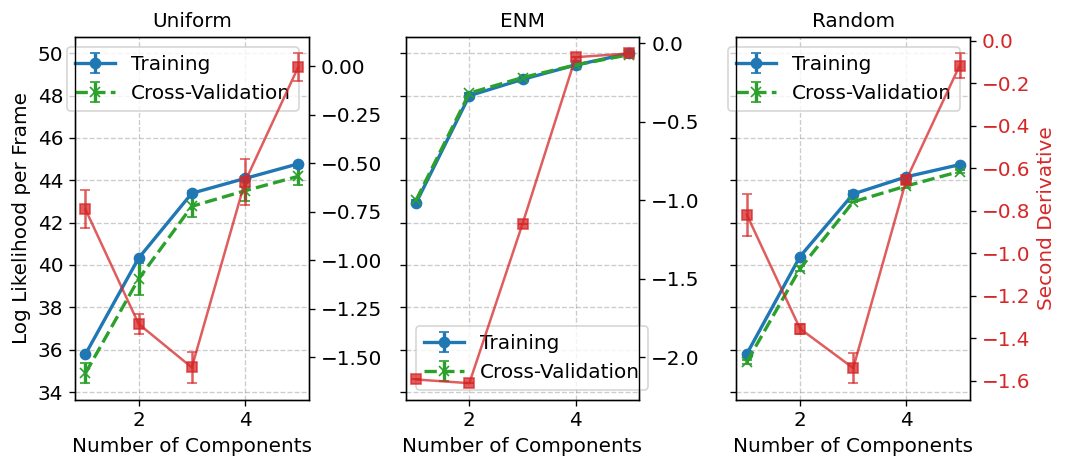

In [12]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
from shapeGMMTorch.utils import plotting
# also need to load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
fig, ax = plt.subplots(1,3,figsize=(9,4), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
# Uniform Weights
ax[0].set_title("Uniform",fontsize=12)
plotting.plot_log_likelihood_with_dd(ax[0],component_array,train,cv,fontsize=12,ylabel1=True,ylabel2=False,xlabel=True)
# ENM Weights
ax[1].set_title("ENM",fontsize=12)
plotting.plot_log_likelihood_with_dd(ax[1],component_array,enm_train,enm_cv,fontsize=12,ylabel1=False,ylabel2=False,xlabel=True)
# Random Weights
ax[2].set_title("Random",fontsize=12)
plotting.plot_log_likelihood_with_dd(ax[2],component_array,random_train,random_cv,fontsize=12,ylabel1=False,ylabel2=True,xlabel=True)
# show plot
plt.tight_layout()
plt.show();

## Fit a $n_{clusters}=2$ object with ENM weights

In [15]:
# fit a shapeGMM object for n=2 with ENM weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_enm_weights = sgmm_fit_with_attempts(traj_data, 2, 10, frame_weights = frame_weights, device=device, dtype=dtype)

Number of components    : 2
Number of attempts      : 10
Covariance type         : kronecker
Data type (dtype)       : torch.float64
Device                  : cpu
Number of train frames  : 10001
Number of atoms         : 12
Init Component Method   : kmeans++
Random seed             : 1234
 Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------
       1             48.0055           0.655
       2             48.0077           0.693
       3             48.0079           0.620
       4             48.0077           0.623
       5             48.0027           1.131
       6             48.0077           0.689
       7             48.0054           0.621
       8             48.0078           0.610
       9             48.0055           0.616
      10             48.0077           0.557
